# Layers


### Contents

* [Fully Connected Layer](#Fully-Connected-Layer)
* [Convolutional Layers](#Convolutional-Layer)
    * [Convolutional Layers in MXNet](#Convolutional-Layers-in-MXNet)
* [Pooling](#Pooling)
    * [Pooling in MXNet](#Pooling-in-MXNet)
* [RNN and LSTMs](#RNN-and-LSTMs)
    * [LSTMS](#LSTMS)
    * [LSTMS in MXNet](#LSTMS-in-MXNet)
* [Embedding Layers](#Embedding-Layers)
    * [Embedding Layers in MXNet](#Embedding-Layers-in-MXNet)   
* [Batch Normalization Layers](#Batch-Normalization-Layers)
    * [Batch Normalization Layers in MXNet](#Batch-Normalization-Layers-in-MXNet)    
* [Dropout Layers](#Dropout-Layers)
    * [Dropout Layers in MXNet](#Dropout-Layers-in-MXNet)

# Fully Connected Layer

A fully connected layer has full connections to all activations in the previous layer. When we defined layers as $W$ in previous chapters, a 'fully connected' layer is what $W$ refers to.

In [2]:
import mxnet as mx

batch_size = 15

data = mx.sym.Variable('data',shape=[batch_size,100])

fc = mx.sym.FullyConnected(data = data, name='fc1', num_hidden=100)

# Convolutional Layer

The CONV layer’s parameters consist of a set of learnable filters based on [the convolutional function](https://en.wikipedia.org/wiki/Convolution). 

During the forward operation, we slide each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position.
 
<img src='files/conv.png'> 
 
This example might look scary but it's not. During the learning, our goal is to learn filters similar to the ones below.  
 
<img src='files/filters.png'>

The end result are learned filters that might look like this

<img src='files/weights.jpeg'>


The goal of convolutions in NNs are to learn filters like these


Convolution preserves the spatial relationship between pixels by learning image features using small squares of input data. 


Three important hyperparameters to consider:


    1) Depth of the output volume (batch size, height, width, depth) equates directly to the number of filters used in the convolutional layer. Note: each filter is itself a hyperparameter, and in this case, is looking for something separate and distinct within the input.

    2) Setting the stride size can dictate the volume size of the output. Setting the stride to 1 moves the filters over one pixel at a time, setting the stride to 2 moves the filters over 2 pixels at a time, etc. Thus, setting the stride to a larger pixel jump results in a smaller volumes spatially. 

    3) Padding the input is a convenient way to control the size of the output volume. 


Convolution Arithmetic to ensure that all hyperparameters 'fit':

    Number of filters (K)
    Input volume size (W)
    Kernal size (F)
    Stride length (S)
    Pad on border (P)
    Fit = (W−F+2P)/S+1

Together these parameters produces a volume of size W2×H2×D2 where:

    W2=(W1−F+2P)/S+1
    H2=(H1−F+2P)/S+1 (i.e. width and height are computed equally by symmetry)
    D2=K

A note on 'fit': if the fit is not an integer, than the hyperparameter choices won't work. 

Formally: The n-th depth slice (size W2×H2) is the result of performing a valid convolution of the d-th filter over the input volume with a stride of S, and then offset by d-th bias.

## Convolutional Layers in MXNet

In [3]:
image_height = 100
image_width = 100
image_depth = 3 #rgb
# 100,100,3


reshaped_data_shape = [batch_size, image_depth, image_height, image_width]

data = mx.sym.Variable('data',shape = reshaped_data_shape)

conv = mx.symbol.Convolution(data=data,
                             name='conv',
                             kernel=(2, 2), 
                             pad=(2, 2), 
                             num_filter=256)

print("Stride Sizes' Effect on Output Shape")
for size in range(1,8):
    conv = mx.symbol.Convolution(data=data,
                             name='conv',
                             kernel=(2, 2), 
                             stride=(size,size),
                             pad=(1, 1), 
                             num_filter=200)
    op = conv.simple_bind(mx.cpu(), data=reshaped_data_shape)
    print("stride size: {}, result shape: {}".format((size,size),op.forward()[0].shape))
      
print("Kernel Sizes' Effect on Output Shape")
for size in range(1,8):
    conv = mx.symbol.Convolution(data=data,
                             name='conv',
                             kernel=(size, size), 
                             stride=(3,3),
                             pad=(1, 1), 
                             num_filter=200)
    op = conv.simple_bind(mx.cpu(), data=reshaped_data_shape)
    print("kernel size: {}, result shape: {}".format((size,size),op.forward()[0].shape))

Stride Sizes' Effect on Output Shape
stride size: (1, 1), result shape: (15L, 200L, 101L, 101L)
stride size: (2, 2), result shape: (15L, 200L, 51L, 51L)
stride size: (3, 3), result shape: (15L, 200L, 34L, 34L)
stride size: (4, 4), result shape: (15L, 200L, 26L, 26L)
stride size: (5, 5), result shape: (15L, 200L, 21L, 21L)
stride size: (6, 6), result shape: (15L, 200L, 17L, 17L)
stride size: (7, 7), result shape: (15L, 200L, 15L, 15L)
Kernel Sizes' Effect on Output Shape
kernel size: (1, 1), result shape: (15L, 200L, 34L, 34L)
kernel size: (2, 2), result shape: (15L, 200L, 34L, 34L)
kernel size: (3, 3), result shape: (15L, 200L, 34L, 34L)
kernel size: (4, 4), result shape: (15L, 200L, 33L, 33L)
kernel size: (5, 5), result shape: (15L, 200L, 33L, 33L)
kernel size: (6, 6), result shape: (15L, 200L, 33L, 33L)
kernel size: (7, 7), result shape: (15L, 200L, 32L, 32L)


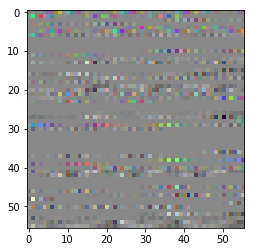

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#!http://data.mxnet.io/models/imagenet/resnet/152-layers/resnet-152-symbol.json
#!http://data.mxnet.io/models/imagenet/resnet/152-layers/resnet-152-0000.params

def norm(x):
    ''' for pretty viz '''
    x_min = np.min(x)
    x_max = np.max(x)
    kernel_0_to_1 = (x - x_min) / (x_max - x_min)
    return kernel_0_to_1


sym, arg_params, aux_params = mx.model.load_checkpoint('files/resnet-152', 0)

conv_layer = norm(arg_params['conv0_weight'].asnumpy())

plt.imshow(conv_layer.reshape(56,56,3))


# Pooling

The function of pooling is the attempt at a spatial reduction of the size of a given representation in an effort to reduce the number of parameters and computation in a given network (as well as to control for overfitting)

A pooling function accepts a volume of size W1×H1×D1, requiring two hyperparameters:

    their spatial extent F
    the stride S

The output of the function produces a volume of size W2×H2×D2 where:

    W2=(W1−F)/S+1
    H2=(H1−F)/S+1
    D2=D1

Introduces zero parameters since it computes a fixed function of the input
Note that it is not common to use zero-padding for Pooling layers 

<img src='files/maxpool.jpeg'>

**Getting rid of pooling** Many people dislike the pooling operation and think that we can get away without it because they think it gets rid of valuable representations during the reduction. In attempt to circumvent this, individuals have started using larger strides in CONV layers once in a while.

# Pooling in MXNet

In [4]:
reshaped_data_shape = [batch_size, image_depth, image_height, image_width]

def print_pool_shape(kernel, stride):
    """
    silly little funct to print the pool operator's shape
    """
    data = mx.sym.Variable('data',shape = reshaped_data_shape)

    conv = mx.symbol.Convolution(data=data,
                                 name='conv',
                                 kernel=(2, 2), 
                                 pad=(2, 2), 
                                 num_filter=256)
    pool = mx.symbol.Pooling(data=conv, kernel=(kernel, kernel), stride=(stride, stride), pool_type="max")
    op = pool.simple_bind(mx.cpu())
    print('kernel: {}'.format(kernel))
    print('stride: {}'.format(stride))
    print("out shape = (103-{})/({}+1) : {}".format(kernel, stride, op.forward()[0].shape))
    print('*----*')

print("Stride Kernel Demo")
shapes = range(1,8)    
for x in range(len(shapes)):
    print_pool_shape(shapes[::-1][x],shapes[x])


Stride Kernel Demo
kernel: 7
stride: 1
out shape = (103-7)/(1+1) : (15L, 256L, 97L, 97L)
*----*
kernel: 6
stride: 2
out shape = (103-6)/(2+1) : (15L, 256L, 49L, 49L)
*----*
kernel: 5
stride: 3
out shape = (103-5)/(3+1) : (15L, 256L, 33L, 33L)
*----*
kernel: 4
stride: 4
out shape = (103-4)/(4+1) : (15L, 256L, 25L, 25L)
*----*
kernel: 3
stride: 5
out shape = (103-3)/(5+1) : (15L, 256L, 21L, 21L)
*----*
kernel: 2
stride: 6
out shape = (103-2)/(6+1) : (15L, 256L, 17L, 17L)
*----*
kernel: 1
stride: 7
out shape = (103-1)/(7+1) : (15L, 256L, 15L, 15L)
*----*


Andrey Karpathy from the cs231 class:

    
> In practice: use whatever works best on ImageNet. If you’re feeling a bit of a fatigue in thinking about the architectural decisions, you’ll be pleased to know that in 90% or more of applications you should not have to worry about these. I like to summarize this point as “don’t be a hero”: Instead of rolling your own architecture for a problem, you should look at whatever architecture currently works best on ImageNet, download a pretrained model and finetune it on your data. You should rarely ever have to train a ConvNet  from scratch or design one from scratch. I also made this point at the Deep Learning school.

> Compromising based on memory constraints. In some cases (especially early in the ConvNet architectures), the amount of memory can build up very quickly with the rules of thumb  presented above. For example, filtering a 224x224x3 image with three 3x3 CONV layers with 64 filters each and padding 1 would create three activation volumes of size [224x224x64]. This amounts to a total of about 10 million activations, or 72MB of memory (per image, for both activations and gradients). Since GPUs are often bottlenecked by memory, it may be necessary to compromise. In practice, people prefer to make the compromise at only the first CONV layer of the network. For example, one compromise might be to use a first CONV layer with filter sizes of 7x7 and stride of 2 (as seen in a ZF net). As another example, an AlexNet uses filter sizes of 11x11 and stride of 4.

# RNN and LSTMs

Recurrent nets allow us to operate over sequences of vectors: Sequences in the input, the output, or in the most general case both.

The image and the accompanying text is from the blogpost [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). It is one of the best breakdowns on recurrent neural networks and lstms that exist to date (7/1/17). 

<img src='files/rnndiags.jpeg'>


>Each rectangle is a vector and arrows represent functions (e.g. matrix multiply). Input vectors are in red, output vectors are in blue and green vectors hold the RNN's state (more on this soon). From left to right: (1) Vanilla mode of processing without RNN, from fixed-sized input to fixed-sized output (e.g. image classification). (2) Sequence output (e.g. image captioning takes an image and outputs a sentence of words). (3) Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment). (4) Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French). (5) Synced sequence input and output (e.g. video classification where we wish to label each frame of the video). Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.

## LSTMS 

(**L**ong **S**hort **T**erm **M**emory)

The pictures from this section are taken from the great [Understanding LSTM and its diagrams](https://medium.com/@shiyan/understanding-lstm-and-its-diagrams-37e2f46f1714) and much of the intuitive explanations are taken from [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

The oringal idea for the LSTM unit was first devised by Sepp Hochreiter and Jürgen Schmidhuber in their 1997 paper 'Long Short-Term Memory'

As you can see from the two diagrams below; the original visual image of the LSTM is a bit cumbersome
<img src='files/lstm_network_original.png'>

<img src='files/lstm_diagram_original.png'>

Thankfully, great minds have clarified its structure in order help individuals visually underunderstand what is happening.  

<img src='files/lstm.png'>

<img src='files/lstmchain.png'>

<img src='files/lstmmem.png'>
The input is the old memory (a vector). The first cross ✖ it passes through is the forget valve. It is actually an element-wise multiplication operation. So if you multiply the old memory C_t-1 with a vector that is close to 0, that means you want to forget most of the old memory. You let the old memory goes through, if your forget valve equals 1.  

Then the second operation the memory flow will go through is this + operator.  New memory and the old memory will merge by this operation. How much new memory should be added to the old memory is controlled by another valve, the ✖ below the + sign

<img src='files/lstmforget.png'>
The first one is called the forget valve. It is controlled by a simple one layer neural network. The inputs of the neural network is h_t-1, the output of the previous LSTM block, X_t, the input for the current LSTM block, C_t-1, the memory of the previous block and finally a bias vector b_0. This neural network has a sigmoid function as activation, and it’s output vector is the forget valve, which will applied to the old memory C_t-1 by element-wise multiplication.

<img src='files/lstmnewmem.png'>
Now the second valve is called the new memory valve. Again, it is a one layer simple neural network that takes the same inputs as the forget valve. This valve controls how much the new memory should influence the old memory. The new memory itself, however is generated by another neural network. It is also a one layer network, but uses tanh as the activation function. The output of this network will element-wise multiple the new memory valve, and add to the old memory to form the new memory.

<img src='files/lstmupdate.png'>
These two ✖ signs are the forget valve and the new memory valve.

<img src='files/lstmoutput.png'>
And finally, we need to generate the output for this LSTM unit. This step has an output valve that is controlled by the new memory, the previous output h_t-1, the input X_t and a bias vector. This valve controls how much new memory should output to the next LSTM unit.

# LSTMS in MXNet

### Load Data

In [35]:
############ load data ####################
from keras.preprocessing import sequence
from keras.datasets import imdb
import logging
import sys

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32


print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = y_train.reshape((-1, 1))
train_iter = mx.io.NDArrayIter(data = x_train,
                               label = y_train,
                               data_name = 'data',
                               label_name = 'target',
                               batch_size = batch_size,
                               shuffle = True)
y_test = y_test.reshape((-1, 1))
test_iter = mx.io.NDArrayIter(data = x_test,
                               label = y_test,
                               data_name = 'data',
                               label_name = 'target',
                               batch_size = batch_size,
                               shuffle = False)
print(train_iter.provide_data)
print(train_iter.provide_label)

Loading data...
(25000, 'train sequences')
(25000, 'test sequences')
Pad sequences (samples x time)
('x_train shape:', (25000, 80))
('x_test shape:', (25000, 80))
[DataDesc[data,(32, 80L),<type 'numpy.float32'>,NCHW]]
[DataDesc[target,(32, 1L),<type 'numpy.float32'>,NCHW]]


### Define A Network Capable of using an LSTM 

#### Create a data and a target symbolic variable

In [37]:
logging.basicConfig(stream = sys.stdout, level = logging.DEBUG)

# Define the Network #
data = mx.symbol.Variable('data')
target = mx.symbol.Variable('target')

#### Create a data and a target symbolic variable

By using the LSTMCell function, we first need to convert sequential information into an embedding so that it can be read by and LSTM

In [39]:
embedding = mx.symbol.Embedding(data = data,
                                input_dim = max_features, 
                                output_dim = 128)

When you have (or plan to have) more than one Recurrent layer within MXNet, you need to use the SequentialRNNCell() function to add layers. This function allows the stacking of multiple layers, essentially this class acts as a list of which appends new layers into a stack.

In [40]:
stack = mx.rnn.SequentialRNNCell()

Here we simply call 'add' to the stack to pack an LSTMCell with a W size of 128 and a DropoutCell in order to avoid overfitting

In [41]:
stack.add(mx.rnn.LSTMCell(num_hidden = 128))
stack.add(mx.rnn.DropoutCell(0.2))

Next we'll call 'unroll()' on the stack. This function unrolls an RNN for a given number of (>=1) time steps, where the length (int) is the number of steps to unroll. We've already defined our maxlen parameter as 80 (the time-steps that we're allowing our lstm to go for). The result of this function are two variables, 'output' and 'state'. Outputs (list of Symbol or Symbol) – Symbol (if merge_outputs is True) or list of Symbols (if merge_outputs is False) corresponding to the output from the RNN from this unrolling. 'states' (nested list of Symbol) – The new state of this RNN (the memory) after this unrolling. The type of this symbol is same as the output of begin_state().

In [42]:
output, state = stack.unroll(length = maxlen,
                             inputs = embedding, 
                             merge_outputs = True, 
                             layout = 'NTC')

Lastly, we'll connect the output of the lstm to a fully connected layer with 1 output (the binary class 0 or 1), depending on if your training data is one-hot encoded - the layer could have 2 outputs. In order to properly set up the loss function, we'll use the LogisticRegressionOutput class. This applies a logistic function to the input.

$$\frac{1}{1+exp(-x)}$$

To refresh your memory, this sigmoid is used to squash the real-valued output of a linear model into the [0,1] range so that it can be interpreted as a probability. It is suitable for binary classification or probability prediction tasks. 

Lastly as a refresher from our segment on initializers, we'll use a orthogonal init

In [43]:
fc = mx.symbol.FullyConnected(data = output, num_hidden = 1)
pred = mx.symbol.LogisticRegressionOutput(data = fc, label = target)

# declare the model 
model = mx.mod.Module(symbol = pred,
                      data_names = ['data'],
                      label_names = ['target'],
                      context = mx.cpu())

# the cross-entropy loss function for mxnet evaluation callback
metric = mx.metric.CustomMetric(feval=lambda labels, pred: ((pred > 0.5) == labels).mean(),
                                name="acc") 

# fit the model using the metric we've defined above
model.fit(train_data = train_iter,
          eval_data = test_iter,
          optimizer = 'adam',
          eval_metric = metric,
          num_epoch = 1,
          initializer = mx.initializer.Orthogonal(0.25))

# output the score defined by the metric
model.score(test_iter, metric)

INFO:root:Epoch[0] Train-acc=0.800112
INFO:root:Epoch[0] Time cost=69.310
INFO:root:Epoch[0] Validation-acc=0.833040


[('acc', 0.83304028132992325)]

# Embedding Layers

Plain and simple, embeddings act as a parameterized function that maps one object into a high dimensional representation. Most commonly, this object is a word or a given word's index mapped into a multidimensional array; eg, $W(cat)=(0.2, -0.4, 0.7, ...)$. Typically, the function is a lookup table, parameterized by a matrix, $\theta$, with a row for each object (word): $W\theta(wn)=\theta n$).

These structures are used typically in Natural Language Processing to represent words and in [Computer Vision to map faces onto embedded lookup tables](https://arxiv.org/abs/1503.03832)

## Embedding Layers in MXNet

In [55]:
# vocab size
vocabulary_size = 26
seq_len, batch_size = (10, 64)

# our embedding dimensions
embed_dim = 16

letters = mx.sym.Variable('letters')
embedding_op = mx.sym.Embedding(data=letters, 
                                input_dim=vocabulary_size, 
                                output_dim=embed_dim, 
                                name='embed')
# end result 
print("Embedding Shape: {}".format(embedding_op.infer_shape(letters=(seq_len, batch_size))[1]))

Embedding Shape: [(10L, 64L, 16L)]


In [56]:
from mxnet import test_utils
vocab_size, embed_dim = (26, 16)
batch_size = 12
word_vecs = test_utils.random_arrays((vocab_size, embed_dim))

op = mx.sym.Embedding(name='embed', input_dim=vocab_size, output_dim=embed_dim)
x = np.random.choice(vocab_size, batch_size)

y = test_utils.simple_forward(op, embed_data=x, embed_weight=word_vecs)

y_np = word_vecs[x]

test_utils.almost_equal(y, y_np)


True

# Batch Normalization Layers

***Batch Normalization***. A recently (2015) developed technique by Ioffe and Szegedy allows for another technique to combat vanishing or exploding gradients.

$Z = XW$

$\tilde{Z} = Z - \dfrac{1}{m}\sum\limits_{i=1}^m Z_i; $

$\hat{Z} = \dfrac{\tilde{Z}}{\sqrt{\epsilon + \dfrac{1}{m}\sum_{i=1}^m \tilde{Z_i,:}^2} }$

$H = \max\{0,\gamma \tilde{Z} + \beta\}$

#### Batch Norm Logic

Imagine you have a 5 layer, purely linear network with layers labeled $a, b, c, d, e$. 

The value of $a$ will very much determine the the statistics of the activations by the time you get to $d$. 

If we take the gradient of $a$ we might get a very large or a very small number depending on the values of the other parameters within the network (the gradient w.r.t. $a$ is $bcde$.)

By adding normalization steps after each multiplication, the value of $a$ now doesn't actually determine the mean or the standard deviation of $d$. Because of this normalization step, we're able to knockout some of the most important interactions between layers. 

Thus, rather than looking at $a$,$b$,$c$, and $d$ to deterime the mean and standard deviation of $e$; we only need to look at the $gamma$ and $beta$ parameters that we've introduced.

For a great overview of BatchNorm logic, please see [this great lecture by Ian Goodfellow](https://www.youtube.com/embed/Xogn6veSyxA?start=325&end=664&version=3)

## Batch Normalization Layers in MXNet

In [2]:
import mxnet as mx
def batchnorm_forward_numpy(x, gamma, beta, eps):
    N, D = x.shape
    #step1: calculate mean
    mu = 1./N * np.sum(x, axis = 0)
    #step2: subtract mean vector of every trainings example
    xmu = x - mu
    #step3: following the lower branch - calculation denominator
    sq = xmu ** 2
    #step4: calculate variance
    var = 1./N * np.sum(sq, axis = 0)
    #step5: add eps for numerical stability, then sqrt
    sqrtvar = np.sqrt(var + eps)
    #step6: invert sqrtwar
    ivar = 1./sqrtvar
    #step7: execute normalization
    xhat = xmu * ivar
    #step8: Nor the two transformation steps
    gammax = gamma * xhat
    #step9
    out = gammax + beta
    #store intermediate
    cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)
    return out, cache

def do_batch_norm_numpy(h):
    mu = 1/N*np.sum(h,axis =0) # Size (H,) 
    sigma2 = 1/N*np.sum((h-mu)**2,axis=0)# Size (H,) 
    hath = (h-mu)*(sigma2+epsilon)**(-1./2.)
    y = gamma*hath+beta 
    return y

# mxnet equivalent
data = mx.symbol.Variable('data')
weight = mx.sym.Variable(name='fc1_weight')
fc1 = mx.symbol.FullyConnected(data = data, 
                               weight=weight, 
                               name='fc1', 
                               num_hidden=128)
bn1 = mx.symbol.BatchNorm(fc1, name='bn1')
act1 = mx.symbol.Activation(bn1, name='relu1',act_type="relu")

# Dropout Layers

There are a number regularization strategies, but for the sake of this workshop, we'll only talk about the main one used in Neural Networks. The strategy known as **Dropout** is implemented by only keeping a neuron active with some probability p (a hyperparameter - often set by the user to be between .2 and .5), or setting it to zero otherwise. Dropout prevents co-adaptation of neurons by making the presence of other neurons unavailable. In this way, a given neuron cannot rely on other neurons to correct it's mistakes. The diagram below shows the Dropout strategy:

<img src='files/dropout.jpeg'>

## Dropout Layers in Numpy

In [4]:
""" 
Inverted Dropout: Recommended implementation example.
We drop and scale at train time and don't do anything at test time.
More or less, dropout has been shown to be the first-order equivalent to an L2 regularizer. 
"""

p = 0.5 # probability of keeping a unit active. higher = less dropout

def train_step(X):
    # forward pass for example 3-layer neural network
    H1 = np.maximum(0, np.dot(W1, X) + b1)
    U1 = (np.random.rand(*H1.shape) < p) / p # first dropout mask. Notice /p!
    H1 *= U1 # drop!
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    U2 = (np.random.rand(*H2.shape) < p) / p # second dropout mask. Notice /p!
    H2 *= U2 # drop!
    out = np.dot(W3, H2) + b3
  
    # backward pass: compute gradients... (not shown)
    # perform parameter update... (not shown)

def predict(X):
    # ensembled forward pass
    H1 = np.maximum(0, np.dot(W1, X) + b1) # no scaling necessary
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    out = np.dot(W3, H2) + b3

## Dropout Layers in MXNet

In [3]:
# Dropout in mxnet
import numpy as np
import mxnet as mx
np.random.seed(998)

# create input data
input_array = np.array([[3., 0.5,  -0.5,  2., 7.],
                    [2., -0.4,   7.,  3., 0.2]])

# create symbol and executor
a = mx.symbol.Variable('a')
dropout = mx.symbol.Dropout(a, p = 0.2)
executor = dropout.simple_bind(mx.cpu(0),a = input_array.shape)

## If training
executor.forward(is_train = True, a = input_array)
print("Training")
print(executor.outputs[0].asnumpy())
#[[ 3.75   0.625 -0.     2.5    8.75 ]
# [ 2.5   -0.5    8.75   3.75   0.   ]]

## If testing
executor.forward(is_train = False, a = input_array)
print("Testing")
print(executor.outputs[0].asnumpy())
#[[ 3.     0.5   -0.5    2.     7.   ]
# [ 2.    -0.4    7.     3.     0.2  ]]

Training
[[ 3.75   0.625 -0.625  0.     8.75 ]
 [ 0.    -0.5    0.     3.75   0.25 ]]
Testing
[[ 3.          0.5        -0.5         2.          7.        ]
 [ 2.         -0.40000001  7.          3.          0.2       ]]


/Users/krzum/anaconda3/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:23: UserWarning: Calling forward the second time after forward(is_train=True) without calling backward first. Is this intended?
